In [1]:
import arviz as az
import seaborn as sns
from scipy.stats import pearsonr as corrp
import pandas as pd
import matplotlib
import json 
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import seaborn as sns
from scipy.special import expit as logistic

df_new=pd.DataFrame()
df=pd.read_csv('actual_data_realworld_PR.csv')


# ,'m','n','a'
variable_names=['q','e','m','a','b']
bad_queries=['q8','q10','q14','q11',
             'e8','e10','e14','e11',
             'm8','m10','m14','m11',
             'c8','c10','c14','c11',
             'a8','a10','a14','a11',
             'b8','b10','b14','b11',
             'd8','d10','d14','d11']

good_queries=[str(i) for i in [4,
5,7,
13,
16,20,22]]

for sub in df.sub_id.unique():
    df_temp=pd.DataFrame()
    sub_name=[sub]*14
    df_temp['sub_id']=sub_name
    df_temp['v']=[float(int(df[df['sub_id']==sub].v.values))]*14

    #     df_temp['trial']=[1,2,4,5,6,7]
    df_temp['trial']=[*np.arange(1,15)]


    
    for var in variable_names:
        df1=df[df.sub_id==sub]
#         filter_col = [col for col in df if col.startswith(var) and col not in bad_queries]
        filter_col = [col for col in df if col.startswith(var)]

        df1=df1[filter_col]
        df_temp[var]=df1.values[0]
    df_new=pd.concat([df_new,df_temp])
df_new['b_log']=np.log(df_new['b'])

df_new['m_log']=np.log(df_new['m'])

# df_new['d_log']=np.log(df_new['d'])
# df_new['e_raw']=np.exp(df_new['e'])
# df_new['e_raw']=logistic(df_new['e_raw'])
df_new['s_log']=np.log(df_new['a'])
# df_new=df_new[df_new['m_log']>-4]
print(df_new.m_log[0:20])

Q=df_new['q']
sub_id=df_new['sub_id']
trials=df_new['trial']
# df_new=df_new.drop(columns=[sub_id'])
# df_new_std=(df_new-df_new.mean())/df_new.std()

print(df_new.head())

# df_new=df_new[(df_new['e']>0)]


# df_new['a_log']=np.log(df_new['a'])

df_new.to_csv('data_rw_bysub_fixed_full.csv')

df_new_groupby_e=df_new.groupby('e').mean()
# df_new_groupby_b=df_new.groupby('b').mean()
df_new_groupby_m=df_new.groupby('m').mean()
# df_new_groupby_n=df_new.groupby('n').mean()
# df_new_groupby_s=df_new.groupby('a').mean()
df_new_groupby_t=df_new.groupby('trial').mean()
# df_new_groupby_t=df_new.groupby('trial').std()


df_new_groupby_t.to_csv('all_values.csv')
df_new_groupby_t_std=(df_new_groupby_t-df_new_groupby_t.mean())/df_new_groupby_t.std()


print(df_new_groupby_t.corr(method='spearman'))
print(df_new_groupby_t)



/var/folders/t8/0vpf6dyn0q111yjvx8dbs7dc0000gn/T/ipykernel_33670/2074029694.py:60: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(df_new.m_log[0:20])


0    -0.867501
1    -0.798508
2    -0.867501
3    -2.703063
4    -0.798508
5    -3.912023
6    -4.342806
7    -0.867501
8    -4.828314
9    -4.605170
10   -5.521461
11   -0.798508
12   -2.488915
13   -4.074542
0    -0.867501
1    -0.798508
2    -0.867501
3    -2.703063
4    -0.798508
5    -3.912023
Name: m_log, dtype: float64
   sub_id    v  trial  q     e      m        a      b     b_log     m_log  \
0       1  1.0      1  1  7.06  0.420  0.00036  11.49  2.441477 -0.867501   
1       1  1.0      2  1  6.70  0.450  0.00055   6.11  1.809927 -0.798508   
2       1  1.0      3  1  5.51  0.420  0.00170  11.49  2.441477 -0.867501   
3       1  1.0      4  1  5.22  0.067  0.00036   7.78  2.051556 -2.703063   
4       1  1.0      5  1  4.74  0.450  0.00390   6.11  1.809927 -0.798508   

      s_log  
0 -7.929407  
1 -7.505592  
2 -6.377127  
3 -7.929407  
4 -5.546779  
        sub_id   v         q         e         m         a         b  \
sub_id     NaN NaN       NaN       NaN       NaN     

In [3]:
import itertools
def findsubsets(s, n):
    return list(itertools.combinations(s, n))
 
# Driver Code
s = df_new_groupby_t.e.values.tolist()
n = 6


subsets=findsubsets(s, n)
print(len(subsets))

all_max_corrs=[]
all_corrs=[]
all_divergings=[]
c=1
for diverginess in subsets:
    df_temp=df_new_groupby_t[df_new_groupby_t.e.isin(diverginess)]
    succs=df_temp.s_log.values.tolist()
    preds=df_temp.m_log.values.tolist()
    r1,p1=corrp(preds,diverginess)
    r2,p2=corrp(succs,diverginess)
    both_corrs=[np.abs(r1),np.abs(r2)]
    max_corr=np.max(both_corrs)
    all_corrs.append(both_corrs)
    all_max_corrs.append(max_corr)
    all_divergings.append(diverginess)

min_value = min(all_max_corrs)
print(min_value)
index = all_max_corrs.index(min_value)
print(len(preds))
print(all_corrs[index])
print(all_divergings[index])

    

3003
0.35830229021388404
6
[0.35830229021388404, 0.25048043783577667]
(5.51, 5.22, 4.74, 3.75, 3.59, 3.2)


In [490]:
import itertools
def findsubsets(s, n):
    return list(itertools.combinations(s, n))
 
# Driver Code
s = df_new_groupby_t.e.values.tolist()
n = 8


subsets=findsubsets(s, n)
print(len(subsets))

all_min_vars=[]
all_vars=[]
all_divergings=[]
c=1
for diverginess in subsets:
    df_temp=df_new_groupby_t[df_new_groupby_t.e.isin(diverginess)]
    succs=df_temp.s_log.values.tolist()
    preds=df_temp.m_log.values.tolist()
    r1,p1=corrp(preds,diverginess)
    r2,p2=corrp(succs,diverginess)
    #     var(diverginess)*(1-corr^2)
    both_vars=[np.var(diverginess)*(1-r1**2),np.var(diverginess)*(1-r2**2)]
    min_var=np.min(both_vars)
    all_vars.append(both_vars)
    all_min_vars.append(min_var)
    all_divergings.append(diverginess)

max_value = max(all_min_vars)
print(max_value)
index = all_min_vars.index(max_value)
print(len(preds))
print(all_vars[index])
print(all_divergings[index])

    

319770
2.9050625357299844
8
[8.358923760693955, 2.9050625357299844]
(5.34, 3.76, 2.62, 1.46, -1.66, -2.89, -4.54, -6.42)


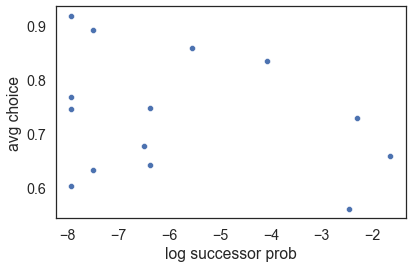

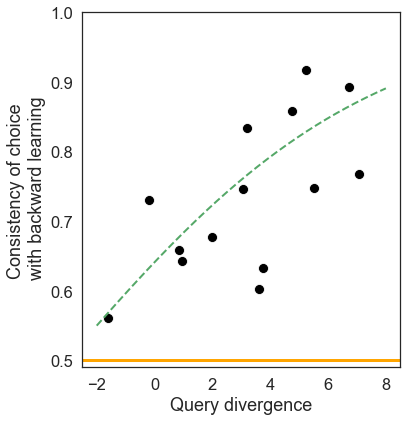

In [8]:
sns.set(style='white', font='arial', font_scale=1.3, rc=None)

ax=sns.scatterplot(x='s_log',y='q',data=df_new_groupby_t)

ax.set(xlabel='log successor prob', ylabel='avg choice')
plt.tight_layout()

# plt.savefig('logbaserateratio_choice_justhigh.png',dpi=300)
plt.show()



# Set style and font
sns.set(style='white', font='arial', font_scale=1.5, rc=None)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(6, 6.2))  # Adjust the figsize to make the height higher than the width
sns.scatterplot(x='e', y='q', data=df_new_groupby_t, marker="o", color='black', s=100, ax=ax)

# Set labels and x-axis range
ax.set(xlabel='Query divergence', ylabel='Consistency of choice\n with backward learning')
ax.set_yticks(np.arange(0.5, 1.10, 0.1))
ax.set_ylim(0.49, 1)  # Ensure y-axis includes the value 1


# Add the green dashed line (replace "actual_values" and "pred_values" with your actual data)
ax.plot(actual_values, pred_values, color='g', linewidth=2, linestyle='dashed')

# Add the legend for the 0.5 marker
ax.axhline(0.5, color='orange',linewidth=3, linestyle='-', label="No evidence of backward learning")

# Save and show the plot
plt.tight_layout()
plt.savefig('scatterplot_diverginess_avgchoice_overlaidSigmoidRegressionLine.png', dpi=300)
plt.show()


In [696]:
print(df_new.head())

   sub_id    v  trial  q     e      m        a      b     b_log     m_log  \
0       1  1.0      1  1  7.06  0.420  0.00036  11.49  2.441477 -0.867501   
1       1  1.0      2  1  6.70  0.450  0.00055   6.11  1.809927 -0.798508   
2       1  1.0      3  0  5.51  0.420  0.00170  11.49  2.441477 -0.867501   
3       1  1.0      4  1  5.22  0.067  0.00036   7.78  2.051556 -2.703063   
4       1  1.0      5  0  4.74  0.450  0.00390   6.11  1.809927 -0.798508   

      s_log  
0 -7.929407  
1 -7.505592  
2 -6.377127  
3 -7.929407  
4 -5.546779  


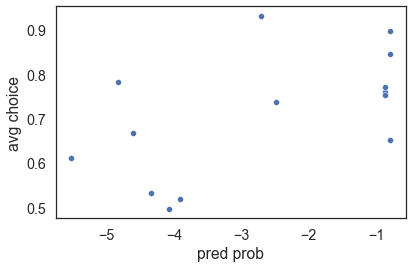

In [592]:
## sns.set(style='white', font='arial', font_scale=1.3, rc=None)

ax=sns.scatterplot(x='m_log',y='q',data=df_new_groupby_t)
ax.set(xlabel='pred prob', ylabel='avg choice')
# plt.ylim([0,1])
plt.tight_layout()
# plt.savefig('diverginess_entropy_choice_demeaned.png',dpi=300)
plt.show()


In [47]:
df_new=df_new.drop(columns=['q','sub_id','trial'])
df_new_std=(df_new-df_new.mean())/df_new.std()
df_new_std['q']=Q
df_new_std['sub_id']=sub_id
df_new_std['trial']=trials
df_new_std.to_csv('data_rw_bysub_fixed_std.csv')

In [107]:
import pymc as pm
from scipy.special import expit 

sub_idxs, subjs = pd.factorize(df_new.sub_id)
trial_idxs,trials = pd.factorize(df_new.trial)
print(trial_idxs)

coords = {
    "subj": subjs,
    "obs_id": np.arange(len(sub_idxs)),
    "trial":trials,
}


    
with pm.Model(coords=coords) as hierarchical_model:
    sub_idxs = pm.Data("sub_idxs", sub_idxs, dims="obs_id")
    trial_idxs = pm.Data("trial_idxs", trial_idxs, dims="obs_id")
    
    log_pred = pm.Data("log_pred_data", df_new.m_log.values, dims="obs_id")
    diverginess = pm.Data("div_data", df_new.e.values, dims="obs_id")

    # Hyperpriors for hierarchical effects of subject and trial
    
    sigma_trial = pm.HalfNormal("var_trial", 1)
    sigma_subject = pm.HalfNormal("var_subj", 1)
    alpha_subject = pm.Normal("alpha_subj", 0,1)

   
    #Fixed effects for diverginess and log_pred_prob and general intercept
    diverginess_effect = pm.Normal("div", 0,1)
    log_pred_effect = pm.Normal("pred", 0,1)
    intercept= pm.Normal("Intercept",0,1)

    
    #subject-level effects of trial and subject
    trial_effect=pm.Normal("trial_effect", mu=0, sigma=sigma_trial, dims="trial")
    subj_effect =pm.SkewNormal("subj_effect", mu=0, alpha=alpha_subject,sigma=sigma_subject, dims="subj")
    theta_raw = pm.Deterministic('integrate_effects',(intercept+(diverginess_effect*diverginess) + (log_pred_effect*log_pred) + subj_effect[sub_idxs] +trial_effect[trial_idxs]))
    theta = pm.Deterministic('logistic link function',(pm.math.invlogit(theta_raw)))

    # Data likelihood
    y = pm.Bernoulli("data",p=theta,observed=df_new.q.values,dims="obs_id")

gv=pm.model_to_graphviz(hierarchical_model)
gv.format = 'png'
gv.render(filename='model_graph')
# plt.show()

[ 0  1  2 ... 11 12 13]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pymc/data.py:406: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  """


'model_graph.png'

In [36]:
import pymc as pm
import numpy as np
import pandas as pd
from scipy.special import expit

sub_idxs, subjs = pd.factorize(df_new.sub_id)
trial_idxs, trials = pd.factorize(df_new.trial)

coords = {
    "subj": subjs,
    "obs_id": np.arange(len(sub_idxs)),
    "trial": trials,
}

with pm.Model(coords=coords) as hierarchical_model2:
    sub_idxs = pm.Data("subject IDs", sub_idxs, dims="obs_id")
    trial_idxs = pm.Data("trials", trial_idxs, dims="obs_id")

    log_pred = pm.Data("log starting state probability data", df_new.m_log.values, dims="obs_id")
    diverginess = pm.Data("divergence data", df_new.e.values, dims="obs_id")

    # Hyperpriors for hierarchical effects of subject and trial
    sigma_trial = pm.HalfNormal("var_trial", 10)
    sigma_subject = pm.HalfNormal("var_subj", 10)

    # Fixed effects for diverginess and log_pred_prob and general intercept
    diverginess_effect = pm.Normal("divergence effect", 0, 1)
    log_pred_effect = pm.Normal("log starting state probability effect", 0, 1)
    intercept = pm.Normal("Intercept", 0, 1)

    # Subject-level effects of trial and subject
    trial_effect = pm.Normal("trial effect", mu=0, sigma=sigma_trial, dims="trial")
    subj_effect = pm.Normal("subject effect", mu=0, sigma=sigma_subject, dims="subj")

    # Reparameterize theta using a Beta distribution
    omega = pm.Deterministic(
        "mu",(intercept
        + (diverginess_effect * diverginess)
        + (log_pred_effect * log_pred)
        + subj_effect[sub_idxs]
        + trial_effect[trial_idxs]))

    theta = pm.Deterministic('logistic link', pm.math.invlogit(omega))

    # Data likelihood
    y = pm.Bernoulli("data", p=theta, observed=df_new.q.values, dims="obs_id")

gv=pm.model_to_graphviz(hierarchical_model2)
gv.format = 'png'
gv.render(filename='model_graph_bayesian_model_PRrealworld')
plt.show()
# with hierarchical_model2:
#     trace_logistic_model2 = pm.sample(draws=1000, target_accept=0.975, tune=500, cores=4)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [136]:
print(az.summary(trace_logistic_model2,var_names=['div','pred','Intercept','var_subj'],hdi_prob=0.95))

            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
div        0.157  0.071     0.023      0.307      0.002    0.002     880.0   
pred       0.082  0.098    -0.107      0.272      0.004    0.003     730.0   
Intercept  0.861  0.435     0.005      1.718      0.015    0.011     813.0   
var_subj   0.549  0.032     0.487      0.611      0.002    0.001     383.0   

           ess_tail  r_hat  
div           962.0   1.00  
pred         1070.0   1.01  
Intercept    1247.0   1.01  
var_subj      989.0   1.00  


In [137]:
import pymc as pm
import numpy as np
import pandas as pd
from scipy.special import expit

sub_idxs, subjs = pd.factorize(df_new.sub_id)
trial_idxs, trials = pd.factorize(df_new.trial)

coords = {
    "subj": subjs,
    "obs_id": np.arange(len(sub_idxs)),
    "trial": trials,
}

with pm.Model(coords=coords) as hierarchical_model3:
    sub_idxs = pm.Data("sub_idxs", sub_idxs, dims="obs_id")
    trial_idxs = pm.Data("trial_idxs", trial_idxs, dims="obs_id")

    log_succ = pm.Data("log_pred_data", df_new.s_log.values, dims="obs_id")
    diverginess = pm.Data("div_data", df_new.e.values, dims="obs_id")

    # Hyperpriors for hierarchical effects of subject and trial
    sigma_trial = pm.HalfNormal("var_trial", 10)
    sigma_subject = pm.HalfNormal("var_subj", 10)

    # Fixed effects for diverginess and log_pred_prob and general intercept
    diverginess_effect = pm.Normal("div", 0, 1)
    log_succ_effect = pm.Normal("succ", 0, 1)
    intercept = pm.Normal("Intercept", 0, 1)

    # Subject-level effects of trial and subject
    trial_effect = pm.Normal("trial_effect", mu=0, sigma=sigma_trial, dims="trial")
    subj_effect = pm.Normal("subj_effect", mu=0, sigma=sigma_subject, dims="subj")

    # Reparameterize theta using a Beta distribution
    omega = pm.Deterministic(
        "mu",(intercept
        + (diverginess_effect * diverginess)
        + (log_succ_effect * log_succ)
        + subj_effect[sub_idxs]
        + trial_effect[trial_idxs]))

    theta = pm.Deterministic('logistic link', pm.math.invlogit(omega))

    # Data likelihood
    y = pm.Bernoulli("data", p=theta, observed=df_new.q.values, dims="obs_id")


with hierarchical_model3:
    trace_logistic_model3 = pm.sample(draws=1000, target_accept=0.975, tune=500, cores=4)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pymc/data.py:406: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  """
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_trial, var_subj, div, succ, Intercept, trial_effect, subj_effect]
INFO:pymc:NUTS: [var_trial, var_subj, div, succ, Intercept, trial_effect, subj_effect]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1124 seconds.
INFO:pymc:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1124 seconds.


In [138]:
print(az.summary(trace_logistic_model3,var_names=['div','succ','Intercept','var_subj'],hdi_prob=0.95))

            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
div        0.234  0.096     0.039      0.413      0.003    0.002    1111.0   
succ       0.077  0.100    -0.119      0.260      0.003    0.002    1079.0   
Intercept  0.855  0.438    -0.017      1.680      0.012    0.009    1260.0   
var_subj   0.543  0.032     0.476      0.602      0.001    0.001     496.0   

           ess_tail  r_hat  
div          1411.0    1.0  
succ         1274.0    1.0  
Intercept    1529.0    1.0  
var_subj     1121.0    1.0  


In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import spearmanr as corr
from scipy.special import expit as logistic
from scipy.special import logit

# Extract posterior samples for the coefficients of x1 and x2
pred_values_based_on_logbaserateratio= []
residual_values = []
pred_values_based_on_entropy=[]
pred_values=[]
actual_values=[x for x in np.arange(-2,8,0.01)]
trial_num=0
print(df_new_groupby_t_std.q)
print(df_new_groupby_t)
for entropy_val in np.arange(-2,8,0.01):
    pred_values.append(logistic(0.19*entropy_val+0.58))
#     print(results_trial_effect5.posterior["e"].values.mean()*entropy_val)
#     actual_values.append(df_new_groupby_t.q[trial_num+1])
    trial_num+=1
    


df_residual=pd.DataFrame()

# df_residual['residual log odds']=residual_values
df_residual['predicted avg choice'] = pred_values
df_residual['avg real choice'] = actual_values 
entropy_values=df_new_groupby_t.e.values
entropy_values=entropy_values.tolist()
print(df_residual)
# df_residual['diverginess']=entropy_values
# df_residual_by_e=df_residual.groupby('diverginess').mean()
# r,p=corr(residual_values,entropy_values)
# print('correlation resid variance average and entropy: {}'.format(r))
# Reshape coefficient samples to match the dimensions of the data



trial
1     0.309320
2     1.432371
3     0.129632
4     1.656981
5     1.126901
6    -0.903575
7    -1.173107
8     0.902291
9     0.111663
10   -0.508261
11   -0.822715
12   -0.678964
13   -0.032087
14   -1.550452
Name: q, dtype: float64
       sub_id         v         q     e      m        a      b     b_log  \
trial                                                                      
1       502.0  3.552343  0.767697  7.06  0.420  0.00036  11.49  2.441477   
2       502.0  3.552343  0.892323  6.70  0.450  0.00055   6.11  1.809927   
3       502.0  3.552343  0.747757  5.51  0.420  0.00170  11.49  2.441477   
4       502.0  3.552343  0.917248  5.22  0.067  0.00036   7.78  2.051556   
5       502.0  3.552343  0.858425  4.74  0.450  0.00390   6.11  1.809927   
6       502.0  3.552343  0.633101  3.75  0.020  0.00055   1.71  0.536493   
7       502.0  3.552343  0.603190  3.59  0.013  0.00036   5.30  1.667707   
8       502.0  3.552343  0.833500  3.20  0.420  0.01700  11.49  2.441477   


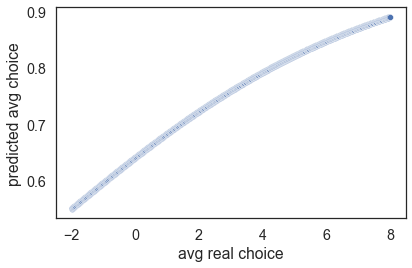

In [18]:
sns.set(style='white', font='arial', font_scale=1.3, rc=None)
ax=sns.scatterplot(x='avg real choice',y='predicted avg choice',data=df_residual)
# plt.plot(X_plot, Y_plot, color='r')
plt.tight_layout()
plt.savefig('sigmoid_pred_actual_choice_from_fixedeffectdiverginess.png',dpi=300)
plt.show()